# Implementation of linear quadratic regulator
This implementation tries to control a quadrotor to stay on a given trajectory using LQR for control in a Mujoco environment.  
Model of the quadrotor comes from the reinmav-gym repo: https://github.com/ethz-asl/reinmav-gym/blob/

In [1]:
import jax
from jax import numpy as jnp
import mujoco
from mujoco import mjx
import mediapy as media
import lqr
import pid
import matplotlib.pyplot as plt

In [2]:
xml = """
<mujoco model="quadrotor0">
	<compiler inertiafromgeom="true" coordinate="local"/>
	<option	timestep="0.01" gravity="0 0 -9.81" density="1" viscosity="1e-5" />
	<worldbody>
		<geom name="floor" pos="0 0 0" size="2 2 .2" type="plane"  conaffinity="1" rgba="1 1 1 1" condim="3"/>
		<body name="quadrotor" pos="0 0 1" >
			<geom name="core" type="box" pos="0 0 0" quat = "1. 0. 0. 0" size="0.06 0.035 0.025"  rgba="0.3 0.3 0.8 1" mass = ".1"/>

			<geom name="a00" type="box" pos=".071 0.071 0.0" size="0.05 0.01 0.0025"  quat = ".924 0.0 0.0 0.383" rgba="0.3 0.3 0.8 1" mass = ".025"/>
			<geom name="a10" type="box" pos=".071 -0.071 0.0" size="0.05 0.01 0.0025"  quat = ".383 0.0 0.0 0.924" rgba="0.3 0.3 0.8 1" mass = ".025"/>
			<geom name="a20" type="box" pos="-0.071 -0.071 0.0" size="0.05 0.01 0.0025"  quat = "-.383 0.0 0.0 0.924" rgba="0.3 0.3 0.8 1" mass = ".025"/>
			<geom name="a30" type="box" pos="-.071 0.071 0.0" size="0.05 0.01 0.0025"  quat = ".924 0.0 0.0 -0.383" rgba="0.3 0.3 0.8 1" mass = ".025"/>

			<joint name="root"   type="free" damping="0" armature="0" pos="0 0 0" />

			<!-- Motor sites to attach motor actuators -->
            <site name="motor0" type="cylinder" pos=" 0.1  0.1 0.01"  size="0.01 0.0025"  quat = "1.0 0.0 0.0 0." rgba="0.3 0.8 0.3 1"/>
            <site name="motor1" type="cylinder" pos=" 0.1 -0.1 0.01"  size="0.01 0.0025"  quat = "1.0 0.0 0.0 0." rgba="0.3 0.8 0.3 1"/>
            <site name="motor2" type="cylinder" pos="-0.1 -0.1 0.01"  size="0.01 0.0025"  quat = "1.0 0.0 0.0 0." rgba="0.3 0.8 0.3 1"/>
            <site name="motor3" type="cylinder" pos="-0.1  0.1 0.01"  size="0.01 0.0025"  quat = "1.0 0.0 0.0 0." rgba="0.3 0.8 0.3 1"/>

			<!-- Thruster geometries for collisions since site's are excluded from collision checking -->
            <geom name="thruster0" type="cylinder" pos=" 0.1  0.1  0.01" size="0.05 0.0025"  quat = "1.0 0.0 0.0 0." rgba="0.3 0.8 0.3 1" mass = ".025"/>
            <geom name="thruster1" type="cylinder" pos=" 0.1 -0.1  0.01" size="0.05 0.0025"  quat = "1.0 0.0 0.0 0." rgba="0.3 0.8 0.3 1" mass = ".025"/>
            <geom name="thruster2" type="cylinder" pos="-0.1 -0.1  0.01" size="0.05 0.0025"  quat = "1.0 0.0 0.0 0." rgba="0.3 0.8 0.3 1" mass = ".025"/>
            <geom name="thruster3" type="cylinder" pos="-0.1  0.1  0.01" size="0.05 0.0025"  quat = "1.0 0.0 0.0 0." rgba="0.3 0.8 0.3 1" mass = ".025"/>

            <!-- Visualization of the coordinate frame -->
			<site name="qcX" type="box" pos="0.1 0.0 0.0" size="0.1 0.005 0.005"  quat = " 1.000  0.0  0.0    0."     rgba="1 0 0 1" />
			<site name="qcY" type="box" pos="0.0 0.1 0.0" size="0.1 0.005 0.005"  quat = " 0.707  0.0  0.0    0.707"  rgba="0 1 0 1" />
			<site name="qcZ" type="box" pos="0.0 0.0 0.1" size="0.1 0.005 0.005"  quat = "-0.707  0.0  0.707  0."     rgba="0 0 1 1" />
		</body>
		<body name="target" pos="0.175 0 0.2">
            <geom type="capsule" fromto="0 0 1  0 0 0.6" size="0.06"/>        
        </body>
	</worldbody>
    <actuator>
        <motor ctrllimited="true" ctrlrange="0.0 1.0" gear="0  0. 1. 0. 0. -0.1" site="motor0"/>
        <motor ctrllimited="true" ctrlrange="0.0 1.0" gear="0  0. 1. 0. 0.  0.1" site="motor1"/>
        <motor ctrllimited="true" ctrlrange="0.0 1.0" gear="0  0. 1. 0. 0. -0.1" site="motor2"/>
        <motor ctrllimited="true" ctrlrange="0.0 1.0" gear="0  0. 1. 0. 0.  0.1" site="motor3"/>
	</actuator>
</mujoco>
"""

In [11]:
mj_model = mujoco.MjModel.from_xml_string(xml)
mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model)

mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)
controller = pid.PID(0.0022, 0.9, 2)

[0. 0. 1. 1. 0. 0. 0.]
Timestep: 15.009999999999724
Error: 0.0074248861540655575 
Integral: 0.7148551277798301
Derivative: 0.00016342603516372733
Proportional: 0.006682397538659002, Gain: 0.9
Torque: 0.7217009513536528
Timestep: 15.019999999999724
Error: 0.0075253304169188295 
Integral: 0.7148716835067472
Derivative: 0.00020088852570654403
Proportional: 0.006772797375226946, Gain: 0.9
Torque: 0.7218453694076807
Timestep: 15.029999999999724
Error: 0.007644312967051925 
Integral: 0.7148885009952748
Derivative: 0.0002379651002661909
Proportional: 0.006879881670346733, Gain: 0.9
Torque: 0.7220063477658877
Timestep: 15.039999999999724
Error: 0.007781618758724962 
Integral: 0.7149056205565439
Derivative: 0.00027461158334607383
Proportional: 0.0070034568828524655, Gain: 0.9
Torque: 0.7221836890227424
Timestep: 15.049999999999724
Error: 0.007937010741037032 
Integral: 0.7149230819801743
Derivative: 0.0003107839646241395
Proportional: 0.0071433096669333285, Gain: 0.9
Torque: 0.7223771756117318


Text(0.5, 0, 'Iterations')

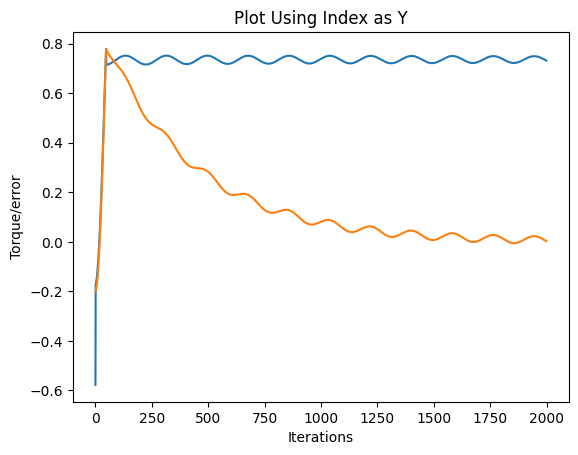

In [12]:
duration = 20 # (seconds)
framerate = 60  # (Hz)
frames = []
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
print(mj_data.qpos)
reference = 0.8
torque_values = []
errors = []
while mj_data.time < duration:
  mujoco.mj_step(mj_model, mj_data)
  torque = controller.control(mj_data.qpos[2],reference, mj_data.time) 
  error = reference - mj_data.qpos[2].item()
  torque_values.append(torque)
  errors.append(error)
  # probably a better way to write this but whatever
  ctrl_vector = jnp.array([torque, torque, torque, torque])
  mj_data.ctrl = ctrl_vector
  #if mj_data.qpos[2] > 0.19 and mj_data.qpos[2] < 0.21:
    #print(ctrl_vector) 

  if len(frames) < mj_data.time * framerate:
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)
print("Sensor data")
# Simulate and display video.
media.show_video(frames, fps=framerate) 
plt.plot(range(len(torque_values)), torque_values)
plt.title('Plot Using Index as Y')
plt.xlabel('Iterations')
plt.ylabel('Torque/error')

plt.plot(range(len(errors)), errors)
plt.title('Plot Using Index as Y')
plt.xlabel('Iterations')